# Egyszerű módszer GPS adatok feldolgozására

Ez a program az androidos "GPS Logger" app kimenetei közül a CSV-t dolgozza fel
Más programokkal is hasonló lenne a módszer, de a beolvasás módját igazítani kell a fájlformátumhoz

In [145]:
import numpy as np
import pandas as pd
%matplotlib inline    
import matplotlib.pyplot as plt

## Beolvasás

In [146]:
# Beolvasott fájl megadása
# A "GPS Logger" kimenetét feltételezi

input_file="./vezetes-1.txt"  # egy Győrön belüli vezetés
#input_file="./vezetes-2.txt"  # egy Győrön belüli vezetés

data=pd.read_csv(input_file,sep=',')

In [147]:
#print(data.describe())   # összefoglaló
print(data.columns)       # oszlopnevek
#print(data.dtypes)       # típusok

Index(['type', 'date time', 'latitude', 'longitude', 'accuracy(m)',
       'altitude(m)', 'geoid_height(m)', 'speed(m/s)', 'bearing(deg)',
       'sat_used', 'sat_inview', 'name', 'desc'],
      dtype='object')


In [148]:
# stringben megadott idő konvertálása a 'date time' oszlop alapján
data["tdat"]=pd.to_datetime(data['date time'], format="%Y-%m-%d %H:%M:%S")

## Előfeldolgozás

In [149]:
# Nem érdekel az abszolút idő, csak a kezdetektől eltelt:
tdat_arr=data.tdat.to_numpy()
t_arr=(tdat_arr-tdat_arr[0])/np.timedelta64(1, 's')  
# most t_arr-ban az első mérési ponttól eltelt idő van
#print(t_arr[:5], "...", t_arr[-5:])

In [150]:
# Földrajzi koordináták konvertálása x-y-ra
# Ez egy közelítő megoldás! 
# Addig jó  közelítés, amíg a pálya mérete sokkal kisebb a Föld sugaránál
# x: nyugatról keletre
# y: délről északra

R_F=6378000.0 # a Föld sugara m-ben

long_arr=np.radians(data.longitude).to_numpy()  # hosszúsági adatok radiánba
lat_arr=np.radians(data.latitude).to_numpy()    # szélességi adatok radiánba

# Most jön maga a konverzió. Origó: 0. mérési pont
# Képzeletben az x és y tengelyeket rágörbítjük a szélességi és hosszúsági körökre.
x_arr=(long_arr-long_arr[0])*np.cos(lat_arr[0])*R_F
y_arr=(lat_arr-lat_arr[0])*R_F



### Egy kis debug

In [170]:
# Néhány általános adat nyomtatása
print("Mérési pontok száma   : %d"%(len(t_arr)))

delta_t=t_arr[-1]-t_arr[0]
print("Időtartam             : %.2f s"%(delta_t))

delta_x=x_arr[-1]-x_arr[0]
delta_y=y_arr[-1]-y_arr[0]
print("Elmozdulás-komponensek: %.2f m, %.2f m"%(delta_x, delta_y))

delta_r_abs=(delta_x**2+delta_y**2)**0.5   # Pitagorasz-tétel
print("Elmozdulás nagysága   : %.2f m"%(delta_r_abs))
print("Átlagsebesség-komponensek: %.2f m/s, %.2f m/s"%(delta_x/delta_t, delta_y/delta_t))
print("Átlagsebesség nagysága   : %.2f m/s"%(delta_r_abs/delta_t))


Mérési pontok száma   : 1494
Időtartam             : 1493.00 s
1493.0
Elmozdulás-komponensek: -2957.50 m, 4795.22 m
Elmozdulás nagysága   : 5633.92 m
Átlagsebesség-komponensek: -1.98 m/s, 3.21 m/s
Átlagsebesség nagysága   : 3.77 m/s


### Egyszerű megjelenítés

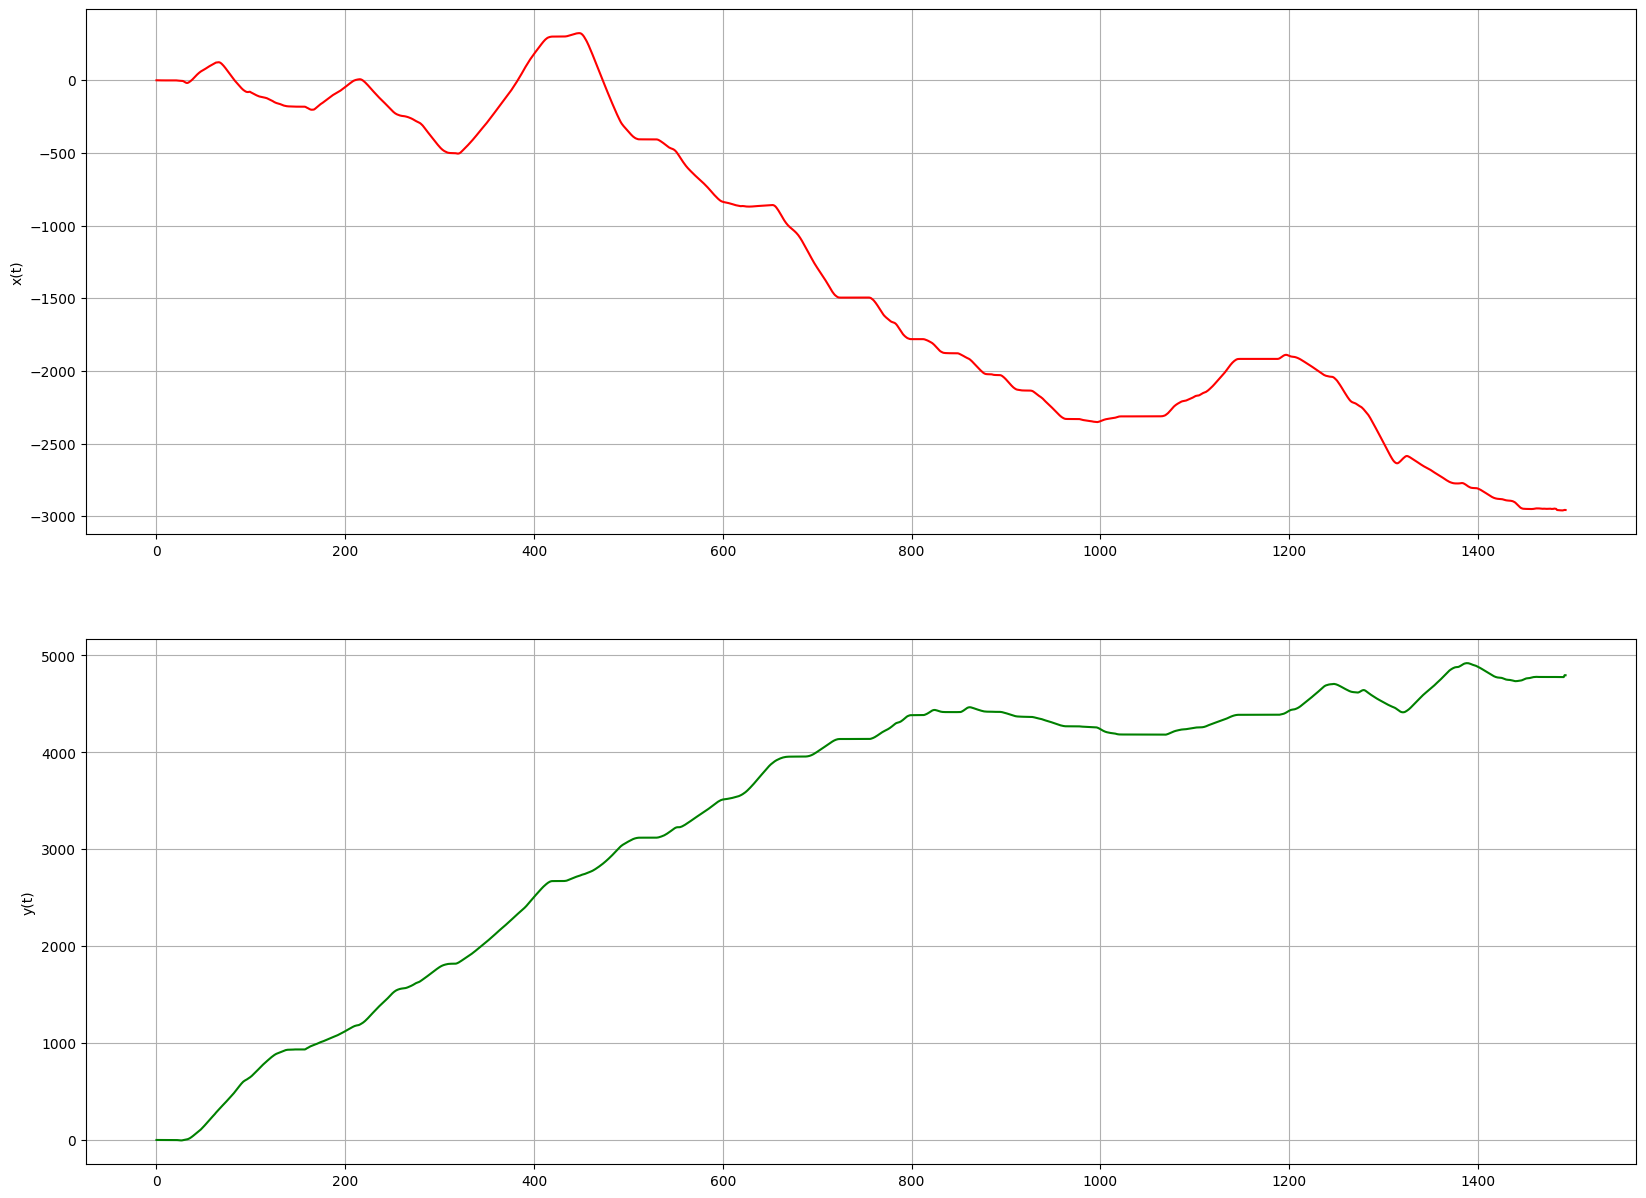

In [152]:
fig=plt.figure(figsize=(20,15))  # rajzméret
ax1=fig.add_subplot(211) # két rész-grafikon
ax2=fig.add_subplot(212)
ax1.set_ylabel("x(t)")
ax1.plot(t_arr, x_arr, color="red") # az elsőbe az x(t)
ax2.set_ylabel("y(t)")
ax2.plot(t_arr, y_arr, color="green") # a másodikba az y(t)
ax1.grid()
ax2.grid()

### Pályagörbe

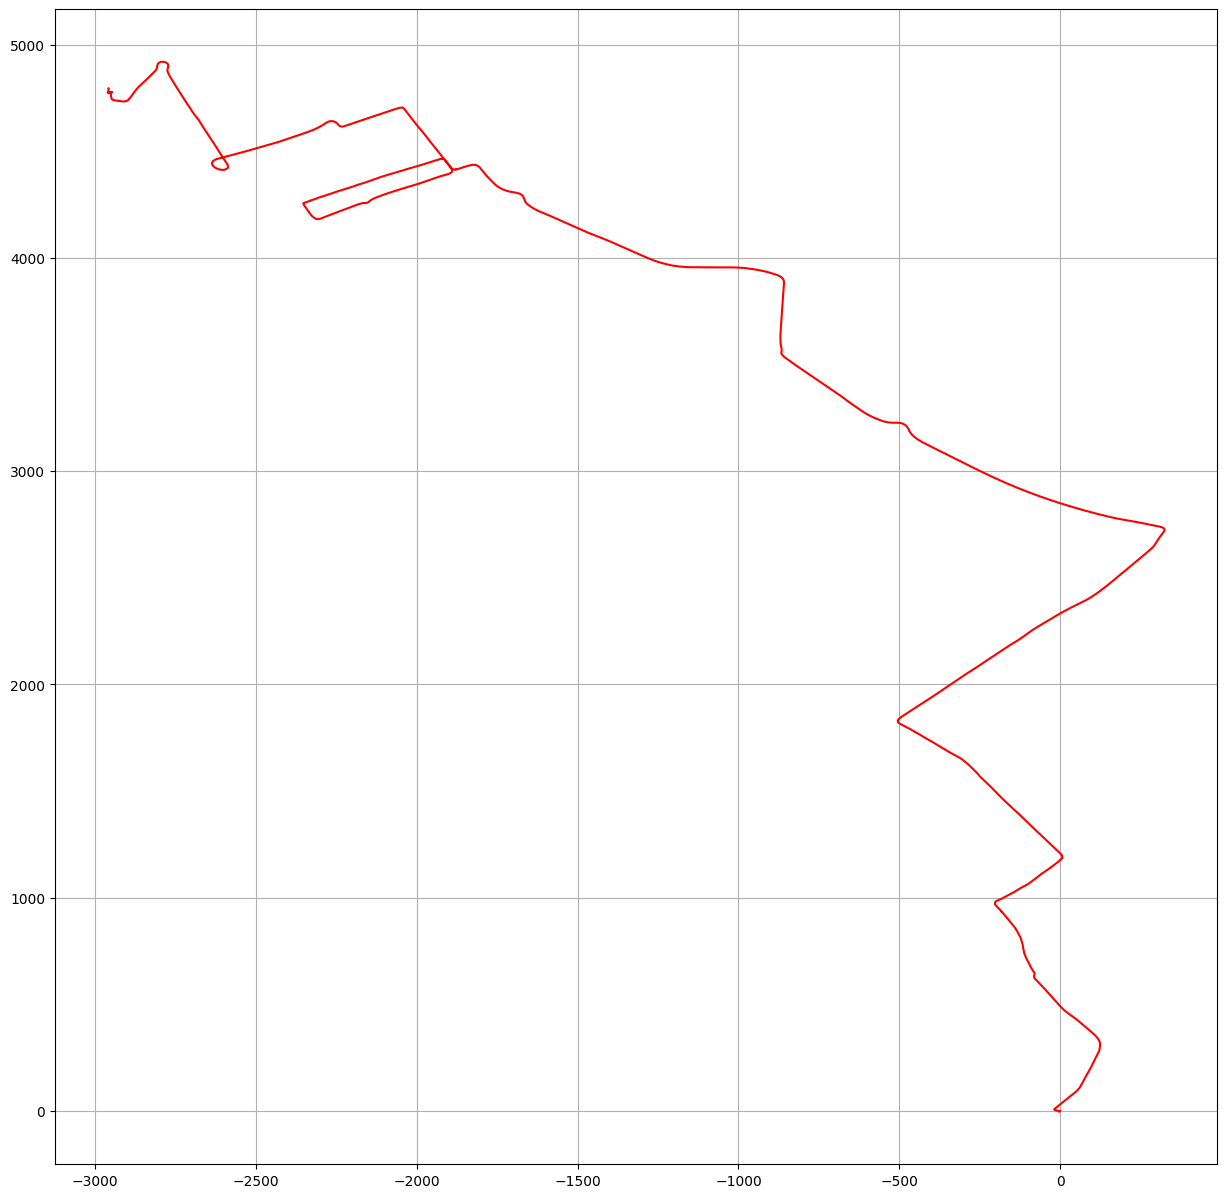

In [153]:
fig=plt.figure(figsize=(15,15))  # rajzméret
ax1=fig.add_subplot(111) 
ax1.plot(x_arr, y_arr, color="red") # x függvényében y
ax1.grid()

Ez így csak első közelítés! Nem látszik pl. az irány, vagy a tengelyeken nem azonos a lépték!

### Kinematikai számítások

In [154]:
# A korábbról vett deriváló rutin vektorizált változata. Gyorsabb és elegánsabb.
# Ez egy igen egyszerű, numerikus közelítés.

def deriv(xx_tab, ff_tab):  # itt 'xx' az általános 'x' változót jelöli, nem az 'x' helykoordinátát!
    dff_dxx=np.zeros(xx_tab.shape, np.float64)
    dff_dxx[0]=(ff_tab[1]-ff_tab[0])/(xx_tab[1]-xx_tab[0]) # eleje
    dff_dxx[-1]=(ff_tab[-1]-ff_tab[-2])/(xx_tab[-1]-xx_tab[-2]) # vége
    dff_dxx[1:-1]=(ff_tab[2:]-ff_tab[0:-2])/(xx_tab[2:]-xx_tab[0:-2])  # közepe
    return(dff_dxx)

In [186]:
# sebesség-komponensek
vx_arr=deriv(t_arr, x_arr)
vy_arr=deriv(t_arr, y_arr)
# sebesség-nagyság:
vabs_arr=(vx_arr**2+vy_arr**2)**0.5

######################################################################
# Szorgalmi modifikáció - Székely Dániel - JAXC3C

#v_max = float(input("Enter v_max: "))
v_max = 50/3.6

def calculate_duration_of_high_speed(v_list, v_max):
    high_speed_duration = 0
    for v in v_list:
        if v > v_max:
            high_speed_duration += 1
    return high_speed_duration

# BETA
def calculate_new_duration(v_list, v_max, original_duration):
    high_speed_duration = calculate_duration_of_high_speed(v_list, v_max)
    if high_speed_duration != 0:
        new_duration = original_duration - high_speed_duration + len(v_list)
        return new_duration
    else:
        return original_duration


high_speed_duration = calculate_duration_of_high_speed(vabs_arr,v_max)
print(f"A mozgas sebesseg-nagysaga (> {v_max}) {high_speed_duration} masodpercig volt nagyobb")


new_duration = calculate_new_duration(vabs_arr, v_max, delta_t)
print(f"Az uj idotartam, ha korlatozzuk a sebesseget {v_max}-re valahanyszor meghaladja {v_max}-t akkor {new_duration} masodperc")

######################################################################


A mozgas sebesseg-nagysaga (> 13.88888888888889) 72 masodpercig volt nagyobb
Az uj idotartam, ha korlatozzuk a sebesseget 13.88888888888889-re valahanyszor meghaladja 13.88888888888889-t akkor 2915.0 masodperc


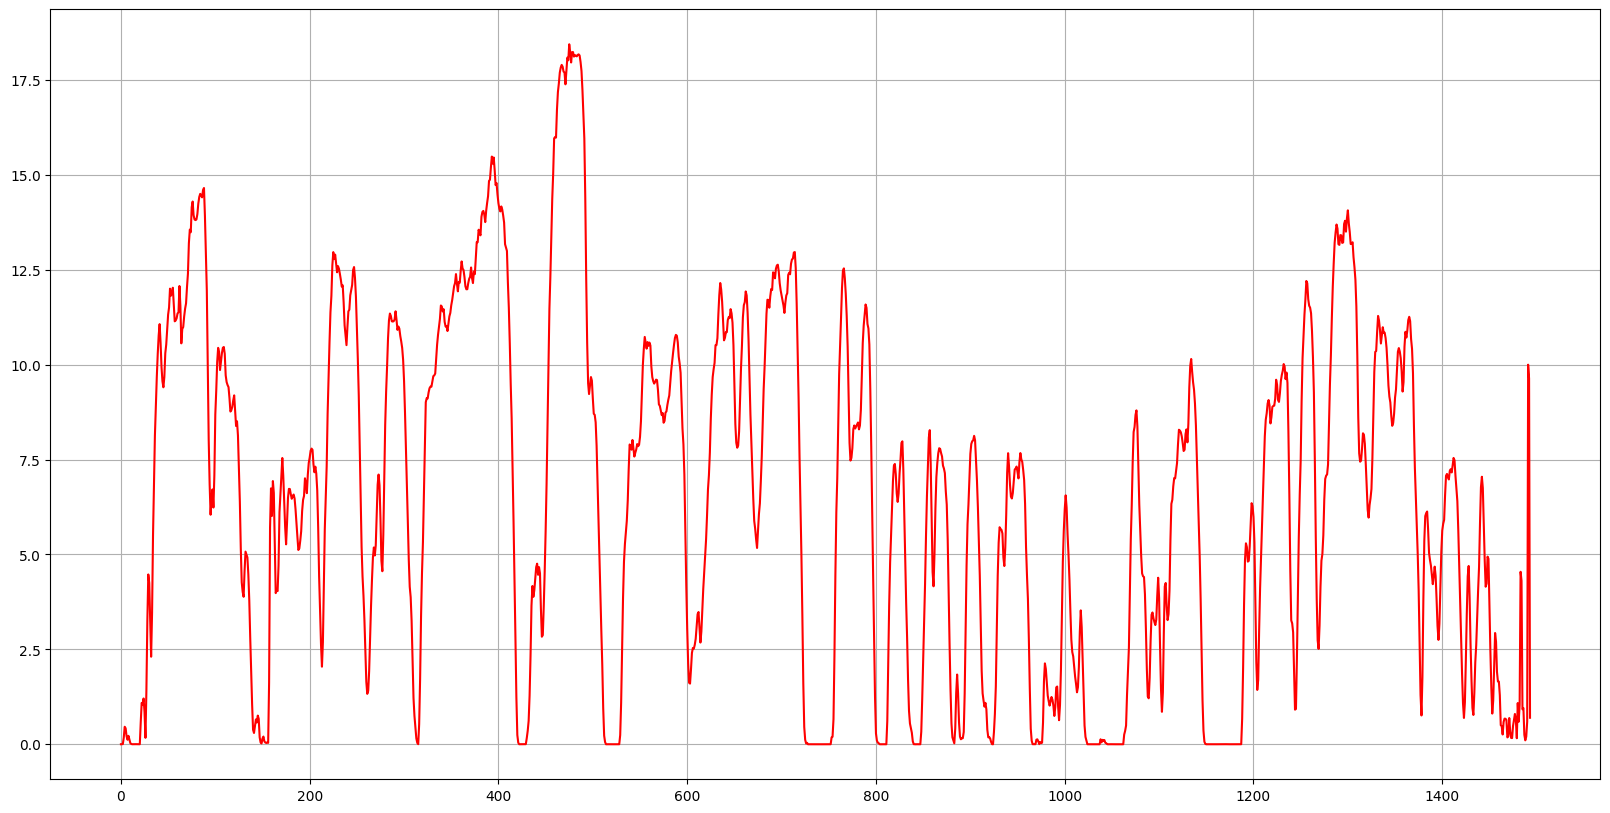

In [156]:
# hogyan alakult a sebesség nagysága?
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(t_arr, vabs_arr, color="red") 
ax1.grid()
# sok mérési adatsor esetén meglehetősen zajos lesz!

In [157]:
# út számítás
ut_arr=np.zeros(t_arr.shape, np.float64)
for i in range(1,len(ut_arr)):
    delta_x=x_arr[i]-x_arr[i-1]
    delta_y=y_arr[i]-y_arr[i-1]
    delta_ut=(delta_x**2+delta_y**2)**0.5
    ut_arr[i]=ut_arr[i-1]+ delta_ut

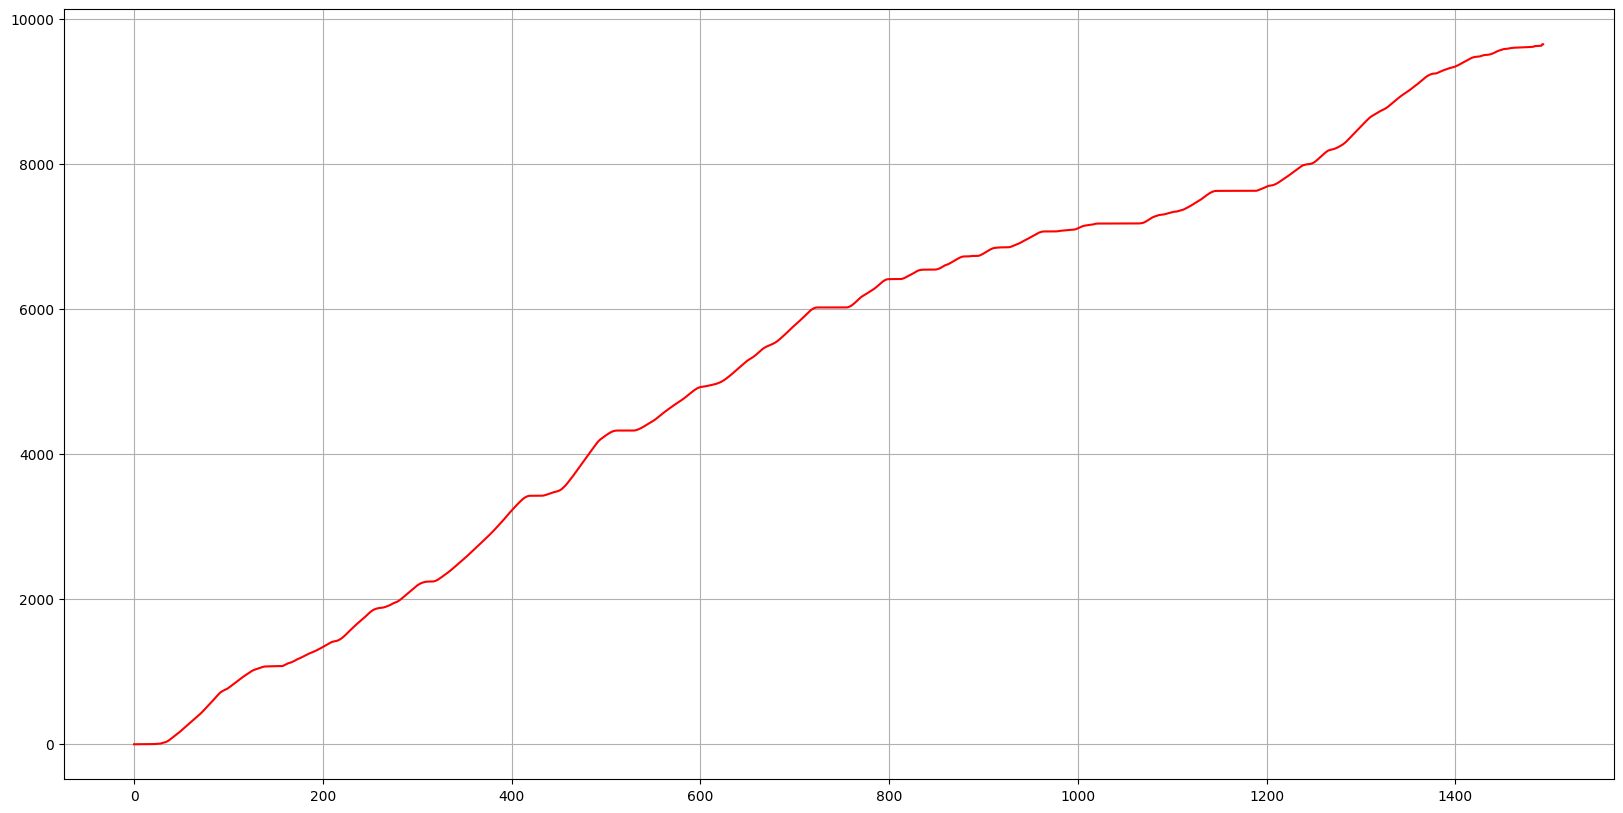

In [158]:
# hogyan alakult az eddig megtett út?
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(t_arr, ut_arr, color="red") 
ax1.grid()
# sokszor meglehetősen zajos lesz!

In [159]:
# teljes utat jellemző adatok:
print("Megtett út              : %.2f m"%(ut_arr[-1]))
print("Átlagos sebesség-nagyság: %0.2f m/s"%(ut_arr[-1]/t_arr[-1]))

Megtett út              : 9650.21 m
Átlagos sebesség-nagyság: 6.46 m/s


In [160]:
# néhány általános adat: (ismétlés)
print("Mérési pontok száma   : %d"%(len(t_arr)))
delta_t=t_arr[-1]-t_arr[0]
print("Időtartam             : %.2f s"%(delta_t))
delta_x=x_arr[-1]-x_arr[0]
delta_y=y_arr[-1]-y_arr[0]
print("Elmozdulás-komponensek: %.2f m, %.2f m"%(delta_x, delta_y))
delta_r_abs=(delta_x**2+delta_y**2)**0.5   # Pitagorasz-tétel
print("Elmozdulás nagysága   : %.2f m"%(delta_r_abs))
print("Átlagsebesség-komponensek: %.2f m/s, %.2f m/s"%(delta_x/delta_t, delta_y/delta_t))
print("Átlagsebesség nagysága   : %.2f m/s"%(delta_r_abs/delta_t))


Mérési pontok száma   : 1494
Időtartam             : 1493.00 s
Elmozdulás-komponensek: -2957.50 m, 4795.22 m
Elmozdulás nagysága   : 5633.92 m
Átlagsebesség-komponensek: -1.98 m/s, 3.21 m/s
Átlagsebesség nagysága   : 3.77 m/s


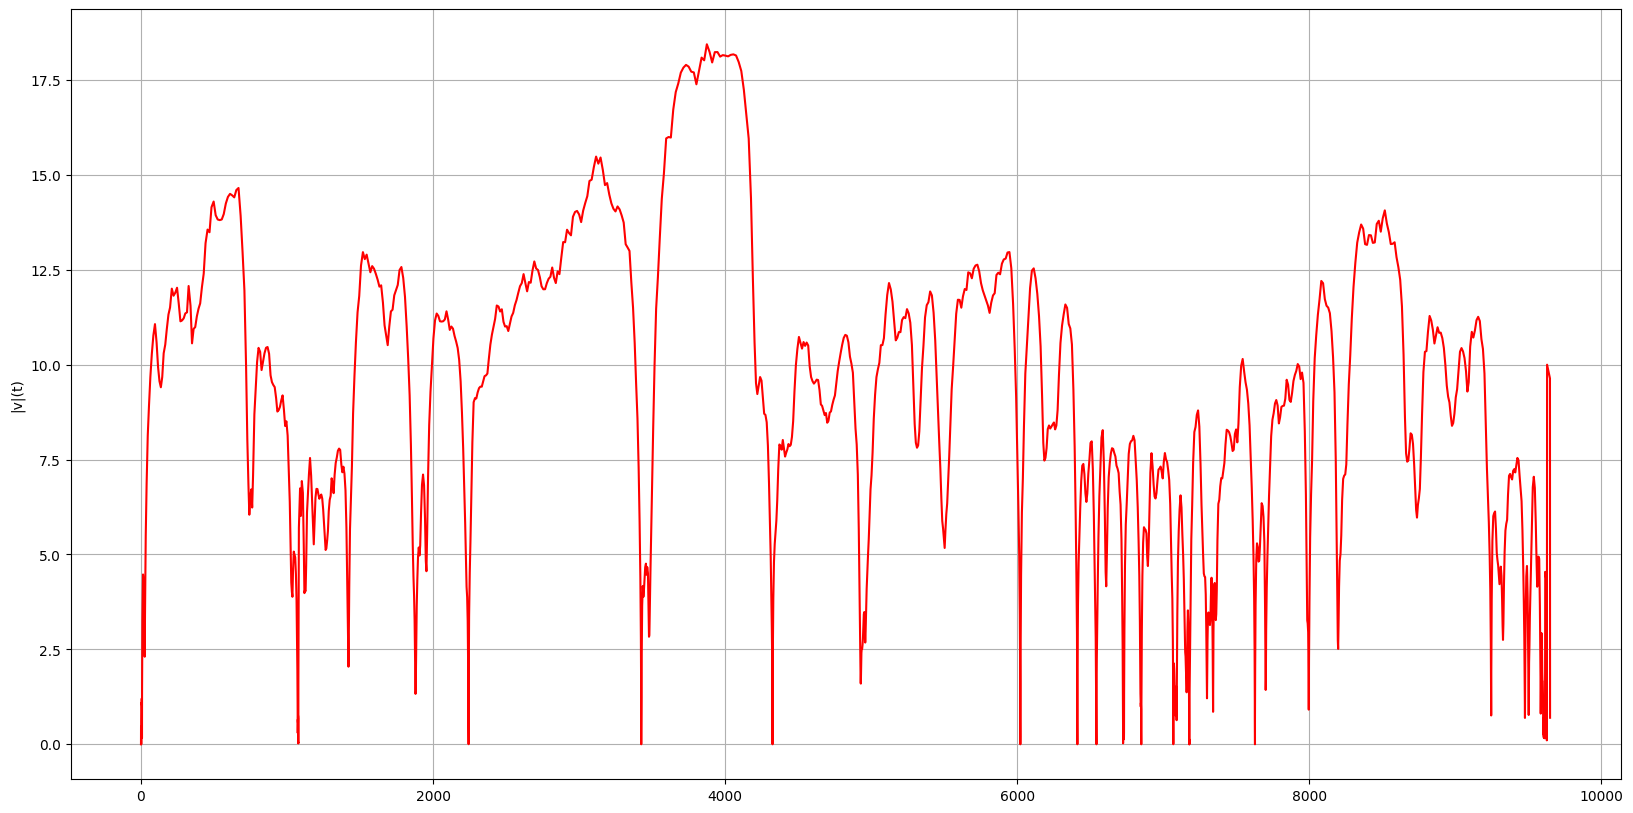

In [161]:
# Egy hasznos diagram: út függvényében a sebesség nagysága
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(ut_arr, vabs_arr, color="red") 
ax1.set_ylabel("|v|(t)")
ax1.grid()